<a href="https://colab.research.google.com/github/UdaraChamidu/Image-Processing-Based-Smart-Waste-Management-System/blob/main/garbage_classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 0: Mount Google Drive
# ============================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set dataset path (change if your dataset folder name is different)
dataset_path = "/content/drive/MyDrive/garbage_classification"

In [ ]:
# ============================
# 📌 STEP 2: Check Dataset Structure
# ============================
import os

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    print(f"Error: Dataset path not found at {dataset_path}")
    print("Please verify the path and ensure Google Drive is mounted correctly.")
else:
    classes = os.listdir(dataset_path)
    print("Available Classes:", classes)

    for cls in classes:
        print(cls, ":", len(os.listdir(os.path.join(dataset_path, cls))), "images")

Available Classes: ['white-glass', 'trash', 'shoes', 'plastic', 'paper', 'metal', 'green-glass', 'brown-glass', 'cardboard', 'biological']
white-glass : 780 images
trash : 697 images
shoes : 1977 images
plastic : 865 images
paper : 1050 images
metal : 769 images
green-glass : 629 images
brown-glass : 607 images
cardboard : 891 images
biological : 985 images


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 128
DATASET_PATH = "/content/drive/MyDrive/garbage_classification"  # Change to your path

images = []
labels = []

print("[INFO] Loading and processing TrashNet dataset...")

def enhance_image(img):
    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram equalization to improve contrast
    equalized = cv2.equalizeHist(gray)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(equalized, (3, 3), 0)

    # Optional: Edge enhancement using Sobel filter
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    sobel_combined = np.uint8(sobel_combined)

    # Normalize to [0,1]
    final = sobel_combined / 255.0

    # Convert back to 3D (grayscale -> fake RGB) for CNN compatibility
    final = cv2.merge([final, final, final])
    return final

# Loop through dataset
for label_folder in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label_folder)
    if not os.path.isdir(label_path):
        continue
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            enhanced_img = enhance_image(img)
            images.append(enhanced_img)
            labels.append(label_folder)
        except Exception as e:
            print(f"[WARN] Skipped corrupt image: {img_path} - {e}")

# Convert to NumPy arrays
X = np.array(images, dtype="float32")
y = np.array(labels)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print(f"[INFO] Dataset ready: {len(X_train)} training samples, {len(X_test)} test samples")

[INFO] Loading and processing TrashNet dataset...
[INFO] Dataset ready: 7400 training samples, 1850 test samples


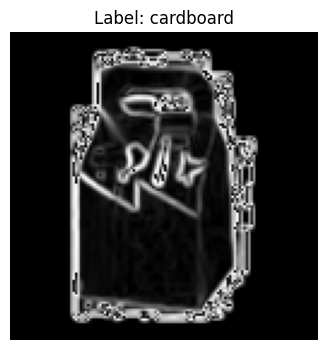

In [ ]:
import matplotlib.pyplot as plt

# Show a sample image from the training set
index = 2000  # Change this to see other images
sample_image = X_train[index]

plt.figure(figsize=(4, 4))
plt.imshow(sample_image)
plt.title(f"Label: {le.inverse_transform([np.argmax(y_train[index])])[0]}")
plt.axis("off")
plt.show()

<Axes: >

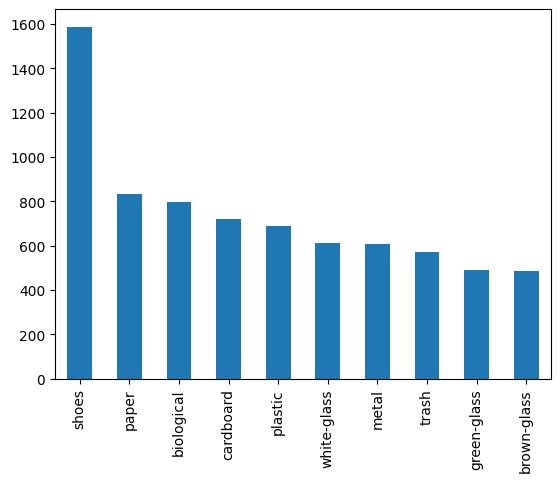

In [ ]:
import pandas as pd
pd.Series(le.inverse_transform(np.argmax(y_train, axis=1))).value_counts().plot(kind='bar')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_SIZE , IMG_SIZE , 3) ,include_top=False,weights='imagenet')
base_model.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)
model_DenseNet121 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(learning_rate=1e-4)

model_DenseNet121.compile(loss ='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(patience=5, restore_best_weights=True , monitor='val_accuracy')
epchos = 20

history = model_DenseNet121.fit(
    X_train,
    validation_data=(X_test, y_test), # Corrected validation data
    epochs=epchos,
    callbacks=[earlystop]
)